# Deep Neural Network Evaluation Report

This notebook evaluates deep neural network models based on their performance metrics.
It visualizes key patterns and provides guidance on model comparison and selection.

# Imports and Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LogNorm
from os.path import join
import ast

# Load your dataset
df = pd.read_csv(join("data", "DNN_trained_models_docs.csv"))

# Filter to only include models from a certain data_file
data_file = "results_3D_GE_Applied_Current_1MKOH_63_02_1MKOH_input_parameters_DOE_maximin_lhs_processed_003.csv"
df = df[df["data_file"] == data_file]

# Add readable column names
df = df.reset_index(drop=True)
df["model_id"] = df.index.map(lambda i: f"Model_{i:03d}")



# 1. Hyperparameter Evaluation

## 1.1 Hidden Layers

This section evaluates how the structure of hidden layers affects model performance.

**Goals:**
- Assess how the number of layers and neurons impacts MAE and RMSE.
- Determine whether larger architectures consistently lead to better models.

**Key Features Evaluated:**
- `num_layers`: total number of hidden layers
- `layer_sizes`: list of neurons per layer
- `total_units`: total number of neurons (sum over all layers)


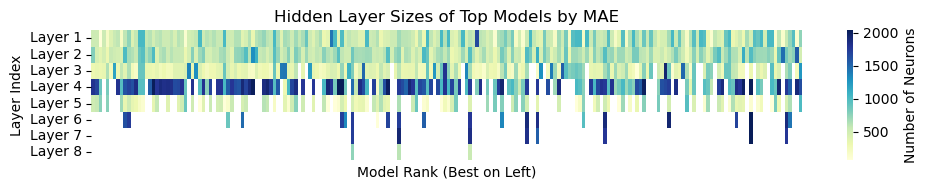

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# --- Top models based on MAE ---
top_models = df.nsmallest(200, "mae")[["model_id", "layer_sizes"]].copy()
top_models["layer_sizes"] = top_models["layer_sizes"].apply(ast.literal_eval)

# Pad with NaN for models with fewer layers
max_layers = max(len(l) for l in top_models["layer_sizes"])
layer_matrix = [l + [np.nan] * (max_layers - len(l)) for l in top_models["layer_sizes"]]
layer_df = pd.DataFrame(layer_matrix, index=top_models["model_id"])
layer_df.columns = [f"Layer {i+1}" for i in range(max_layers)]

# Replace zeros with NaN (if any)
layer_df_safe = layer_df.replace(0, np.nan)

# Transpose and reverse columns so best model is on the left
layer_df_safe_T = layer_df_safe.T # Transpose + flip columns

# Plot heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(
    layer_df_safe_T,
    annot=False,
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Neurons'},
    vmin=layer_df_safe.min().min(),
    vmax=layer_df_safe.max().max()
)
plt.title("Hidden Layer Sizes of Top Models by MAE")
plt.ylabel("Layer Index")
plt.xlabel("Model Rank (Best on Left)")
plt.xticks([], [])
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


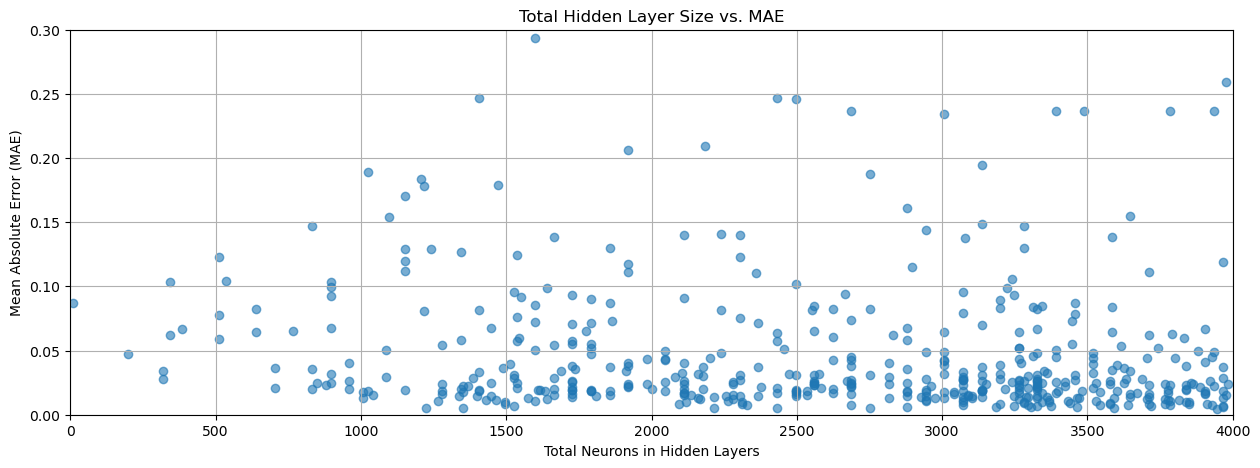

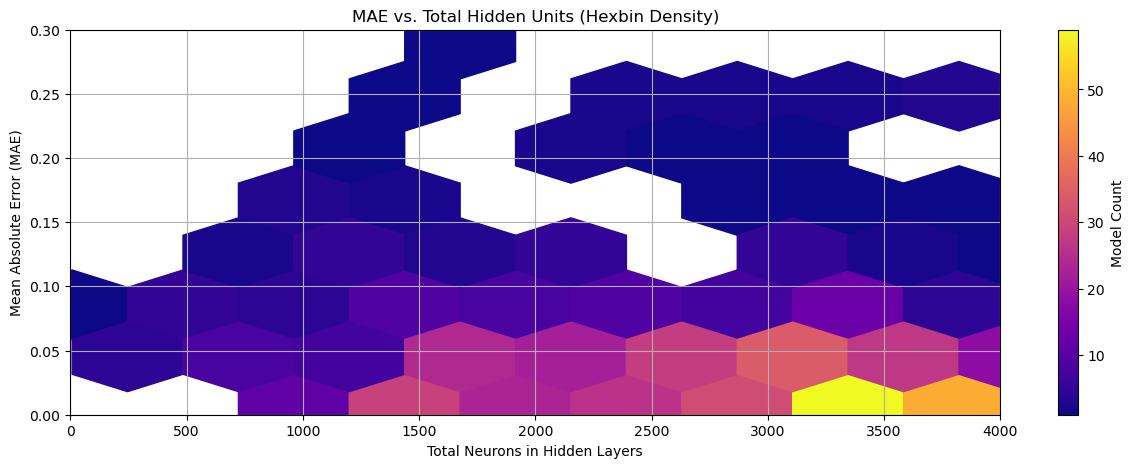

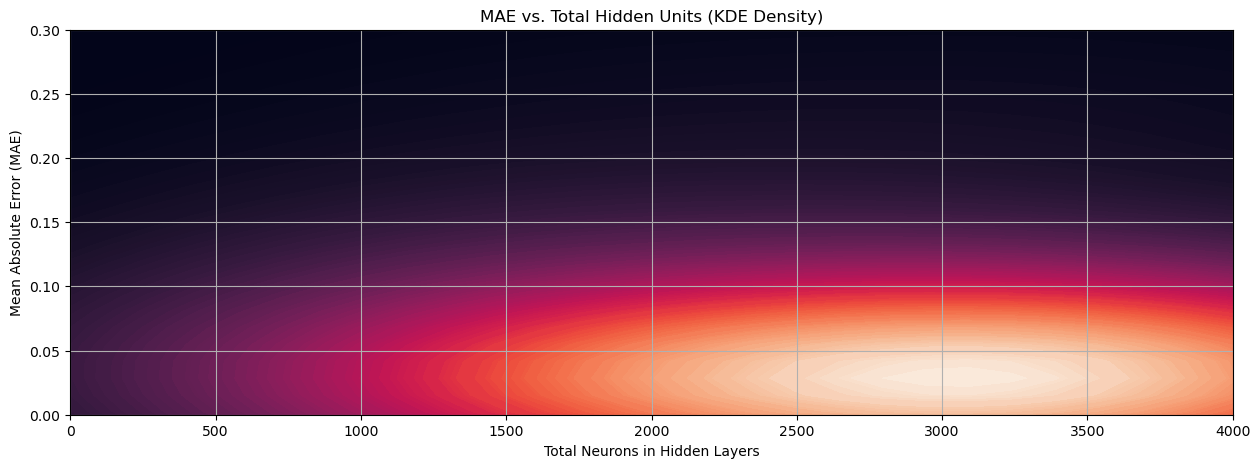

C:\Users\ebben\AppData\Local\Temp\ipykernel_35608\3019260660.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby("bin")["mae"].median().reset_index()


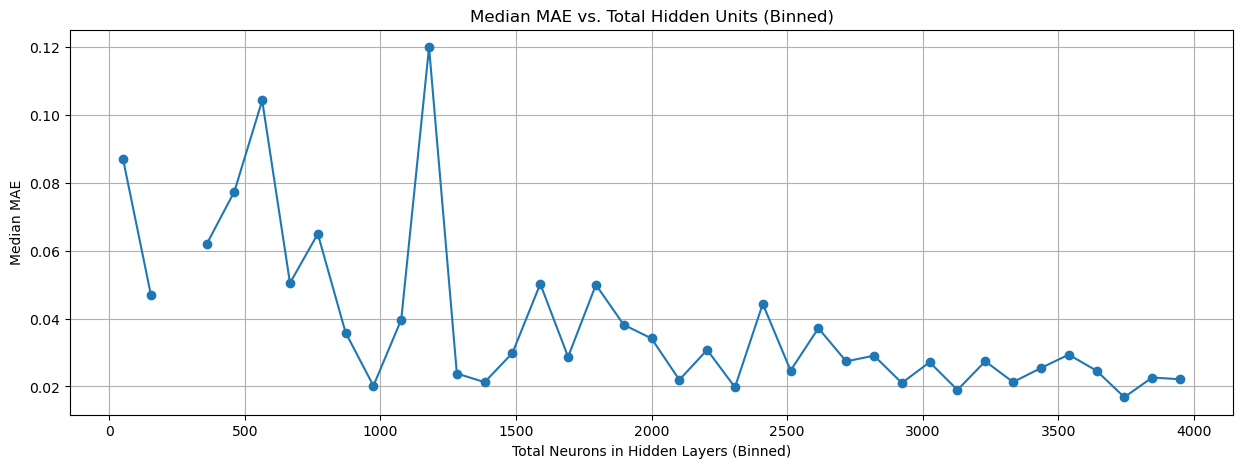

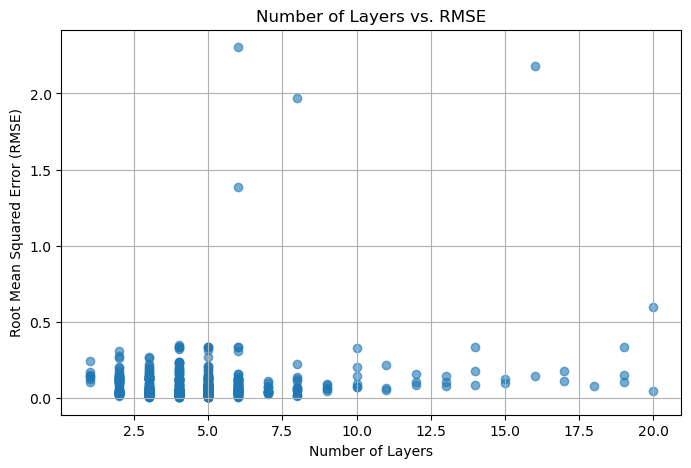

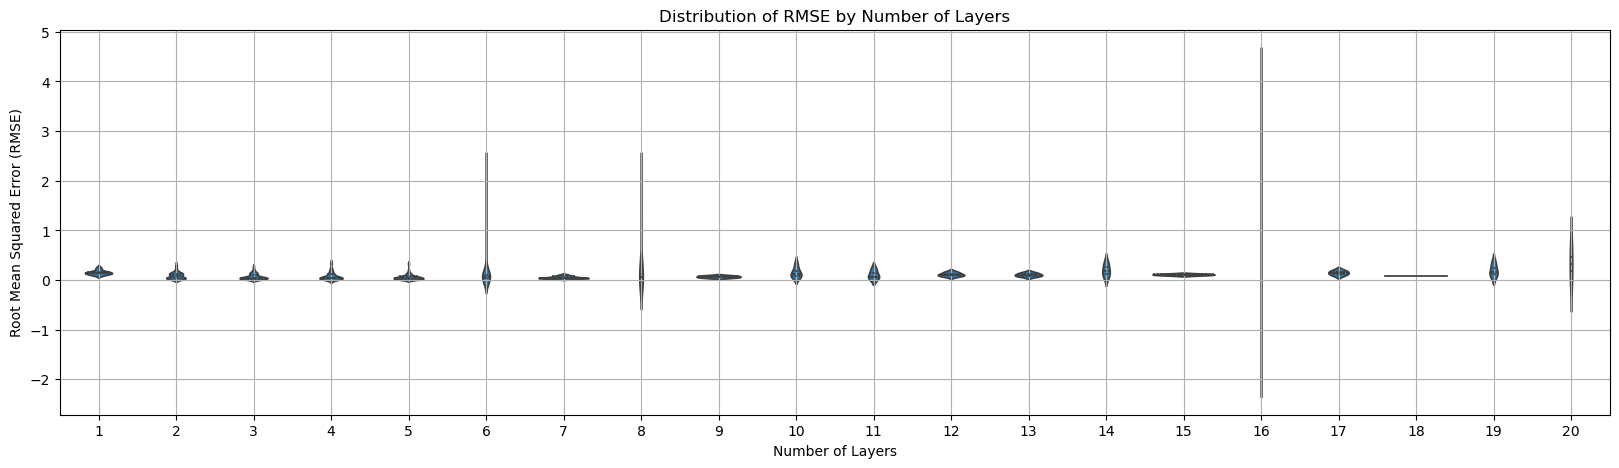

In [21]:
# Parse layer sizes into a list and compute total units
df["layer_sizes_list"] = df["layer_sizes"].apply(ast.literal_eval)
df["total_units"] = df["layer_sizes_list"].apply(sum)



# Plot: Total units vs MAE
plt.figure(figsize=(15, 5))
plt.scatter(df["total_units"], df["mae"], alpha=0.6)
plt.ylim(0, 0.3)
plt.xlim(0, 4000)
plt.xlabel("Total Neurons in Hidden Layers")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Total Hidden Layer Size vs. MAE")
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))
hb = plt.hexbin(df["total_units"], df["mae"], gridsize=50, cmap="plasma", mincnt=1)
plt.colorbar(hb, label="Model Count")
plt.xlabel("Total Neurons in Hidden Layers")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Total Hidden Units (Hexbin Density)")
plt.ylim(0, 0.3)
plt.xlim(0, 4000)
plt.grid(True)
plt.show()

import seaborn as sns

plt.figure(figsize=(15, 5))
sns.kdeplot(
    x=df["total_units"],
    y=df["mae"],
    fill=True,
    cmap="rocket",
    thresh=0.01,
    levels=100
)
plt.xlabel("Total Neurons in Hidden Layers")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Total Hidden Units (KDE Density)")
plt.ylim(0, 0.3)
plt.xlim(0, 4000)
plt.grid(True)
plt.show()



df["bin"] = pd.cut(df["total_units"], bins=np.linspace(0, 4000, 40))
bin_summary = df.groupby("bin")["mae"].median().reset_index()
bin_summary["bin_center"] = bin_summary["bin"].apply(lambda b: b.mid)

plt.figure(figsize=(15, 5))
plt.plot(bin_summary["bin_center"], bin_summary["mae"], marker="o")
plt.xlabel("Total Neurons in Hidden Layers (Binned)")
plt.ylabel("Median MAE")
plt.title("Median MAE vs. Total Hidden Units (Binned)")
plt.grid(True)
plt.show()




# Plot: num_layers vs RMSE
plt.figure(figsize=(8, 5))
plt.scatter(df["num_layers"], df["rmse"], alpha=0.6)
plt.xlabel("Number of Layers")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Number of Layers vs. RMSE")
plt.grid(True)
plt.show()

# Violin Plot: Number of layers vs rmse
plt.figure(figsize=(20, 5))
sns.violinplot(x="num_layers", y="rmse", data=df, inner="quartile")
plt.xlabel("Number of Layers")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Distribution of RMSE by Number of Layers")
plt.grid(True)
plt.show()


## 1.2 Learning Rate

The learning rate controls how quickly the model updates weights during training.

**Too small**: slow convergence  
**Too large**: unstable or divergent training

This plot helps assess how learning rate affects final model performance.


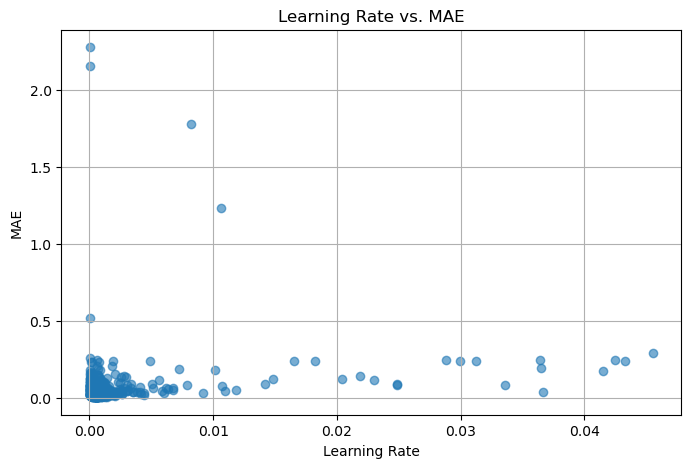

In [4]:
# Plot: learning rate vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["learning_rate"], df["mae"], alpha=0.6)
plt.xlabel("Learning Rate")
plt.ylabel("MAE")
plt.title("Learning Rate vs. MAE")
plt.grid(True)
plt.show()


## 1.3 Epochs

Epochs define how many times the model sees the full training data.

**Fewer epochs**: risk of underfitting  
**Too many**: risk of overfitting

We compare number of epochs to performance metrics and check best_epoch from early stopping.


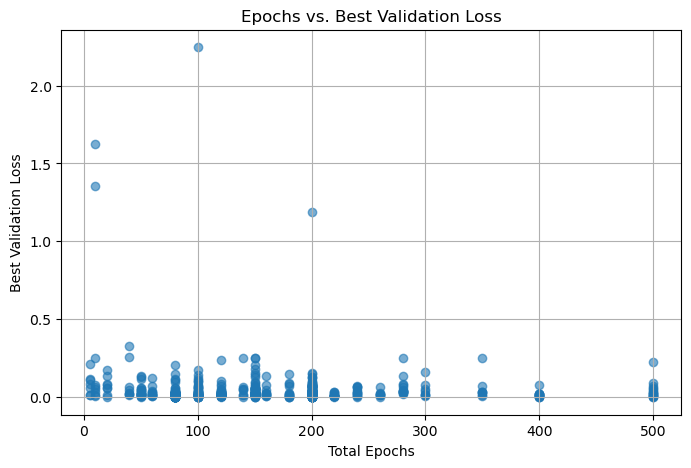

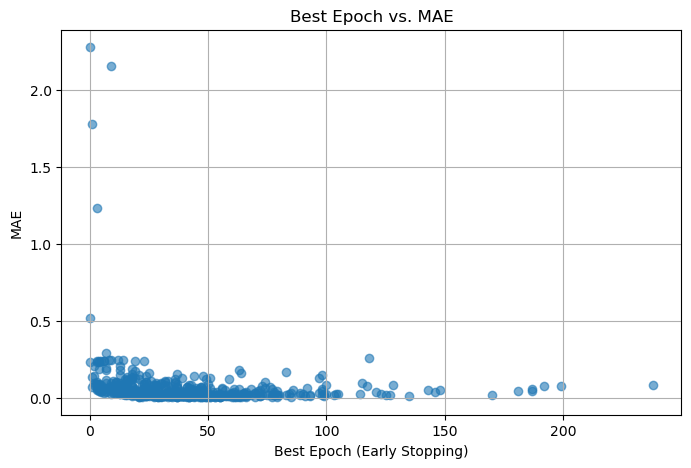

In [5]:
# Plot: epochs vs val_loss_best
plt.figure(figsize=(8, 5))
plt.scatter(df["epochs"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Total Epochs")
plt.ylabel("Best Validation Loss")
plt.title("Epochs vs. Best Validation Loss")
plt.grid(True)
plt.show()

# Plot: best_epoch vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["best_epoch"], df["mae"], alpha=0.6)
plt.xlabel("Best Epoch (Early Stopping)")
plt.ylabel("MAE")
plt.title("Best Epoch vs. MAE")
plt.grid(True)
plt.show()


## 1.4 Batch Size

Batch size controls how many samples are used in each training update.

**Smaller** batches improve generalization but slow training.  
**Larger** batches can speed up training but risk poor minima.

We explore how batch size affects MAE and inference time.


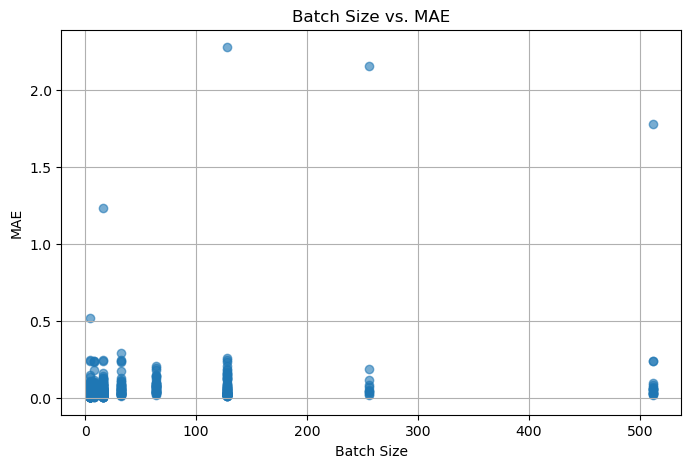

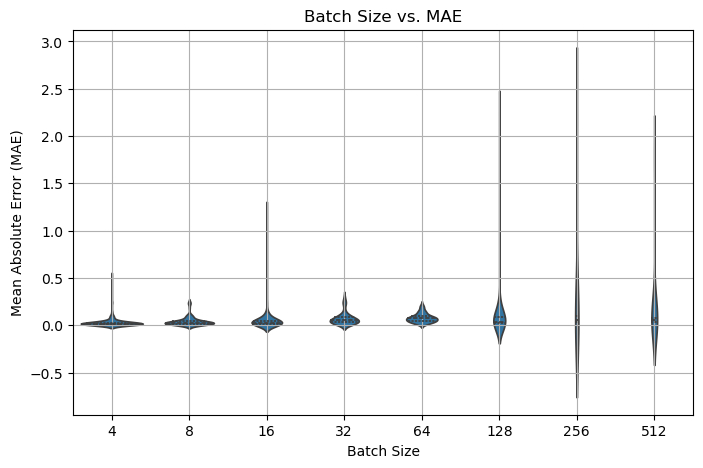

In [6]:
# Plot: batch size vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["batch_size"], df["mae"], alpha=0.6)
plt.xlabel("Batch Size")
plt.ylabel("MAE")
plt.title("Batch Size vs. MAE")
plt.grid(True)
plt.show()

# Violing plot: batch size vs MAE
plt.figure(figsize=(8, 5))
sns.violinplot(x="batch_size", y="mae", data=df, inner="quartile")
plt.xlabel("Batch Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Batch Size vs. MAE")
plt.grid(True)
plt.show()


## 1.5 Activation Function

Activation functions introduce nonlinearity into the network.

Common options:
- `relu`: fast and effective; default in most cases
- `tanh`: squashes output between -1 and 1; can help with symmetry
- `sigmoid`: rarely used in hidden layers due to vanishing gradients

We compare the distribution of MAE across activation functions.


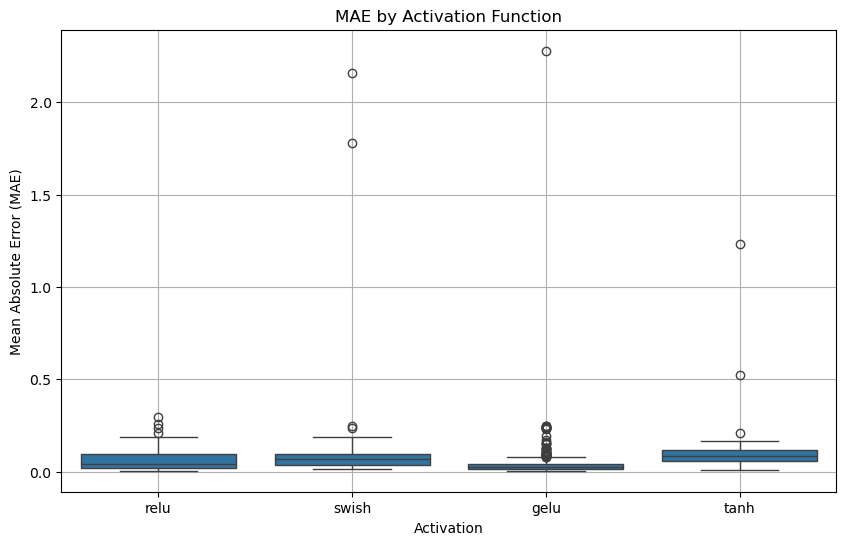

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="activation", y="mae")
plt.title("MAE by Activation Function")
plt.xlabel("Activation")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)
plt.show()


## 1.6 Loss Function

The loss function guides the training process.

For regression, common choices are:
- `mse` (Mean Squared Error): penalizes larger errors more
- `mae` (Mean Absolute Error): less sensitive to outliers

We compare how choice of loss affects model performance.


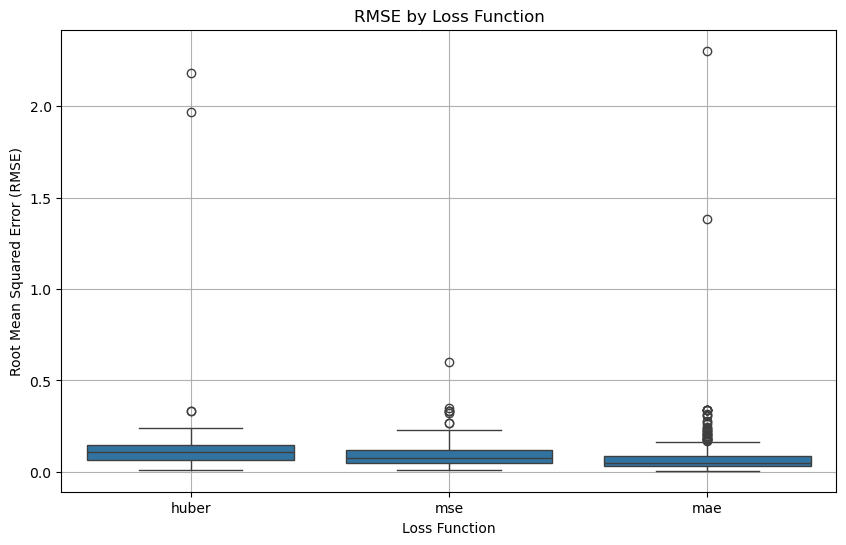

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="loss_function", y="rmse")
plt.title("RMSE by Loss Function")
plt.xlabel("Loss Function")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)
plt.show()


## 1.7 Optimizer

Optimizers update model weights based on gradients. Popular options:
- `Adam`: adaptive learning rate, widely used
- `SGD`: classic stochastic gradient descent
- `RMSprop`: good for recurrent networks

We evaluate how optimizer choice affects composite model quality.


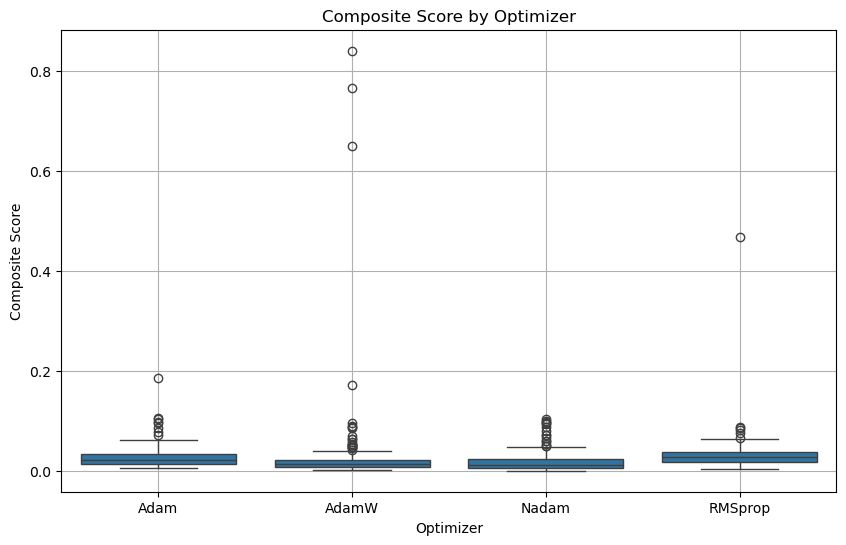

In [9]:
metrics = ["mae", "rmse", "val_loss_best", "mape", "median_ae", "inference_time_ms"]
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[[f"{m}_norm" for m in metrics]] = scaler.fit_transform(df[metrics])
df["composite_score"] = df_norm[[f"{m}_norm" for m in metrics]].mean(axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="optimizer", y="composite_score")
plt.title("Composite Score by Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("Composite Score")
plt.grid(True)
plt.show()


## 1.8 Dropout Rate

Dropout randomly disables neurons during training to prevent co-adaptation.

**Goal:** Improve generalization and reduce overfitting.

Typical range: 0.2 to 0.5.  
We examine how dropout rate affects performance and validation loss.


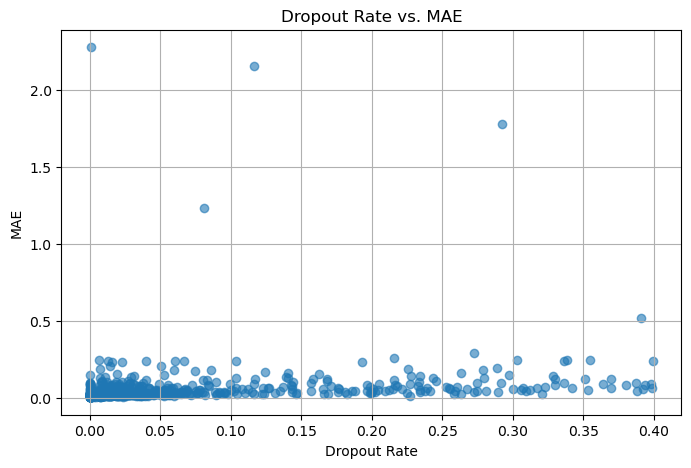

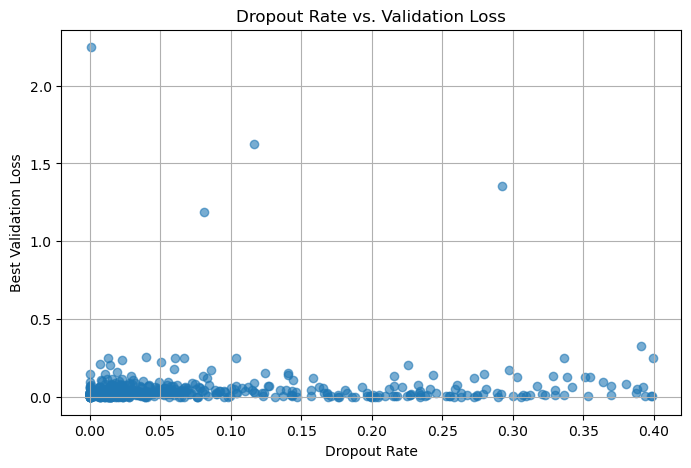

In [10]:
# Plot: dropout vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["dropout_rate"], df["mae"], alpha=0.6)
plt.xlabel("Dropout Rate")
plt.ylabel("MAE")
plt.title("Dropout Rate vs. MAE")
plt.grid(True)
plt.show()

# Plot: dropout vs val_loss_best
plt.figure(figsize=(8, 5))
plt.scatter(df["dropout_rate"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Dropout Rate")
plt.ylabel("Best Validation Loss")
plt.title("Dropout Rate vs. Validation Loss")
plt.grid(True)
plt.show()


# 2. Evaluating All Models Against the Evaluation Metrics




This section visualizes model performance across evaluation metrics to help identify:

- Underperforming models
- Overfitting tendencies
- General trends and trade-offs between metrics

We focus on pairwise metric comparisons and their distribution across the model population.

## 2.1 Validation Loss vs. MAE

This plot highlights how validation loss correlates with Mean Absolute Error (MAE).

**Interpretation:**
- Bottom-left corner: strong models (low validation loss and low MAE)
- Top-right corner: weak or overfitted models
- Discrepancy between validation loss and MAE could indicate poor generalization


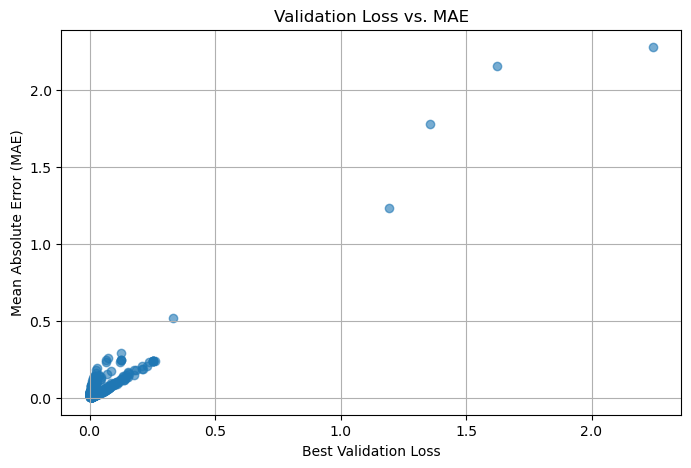

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(df["val_loss_best"], df["mae"], alpha=0.6)
plt.xlabel("Best Validation Loss")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation Loss vs. MAE")
plt.grid(True)
plt.show()


## 2.2 MAE vs. RMSE

This plot compares two error metrics: MAE and RMSE.

**Interpretation:**
- RMSE penalizes large errors more heavily than MAE.
- A strong correlation is expected, but large outliers in RMSE can signal unstable predictions.


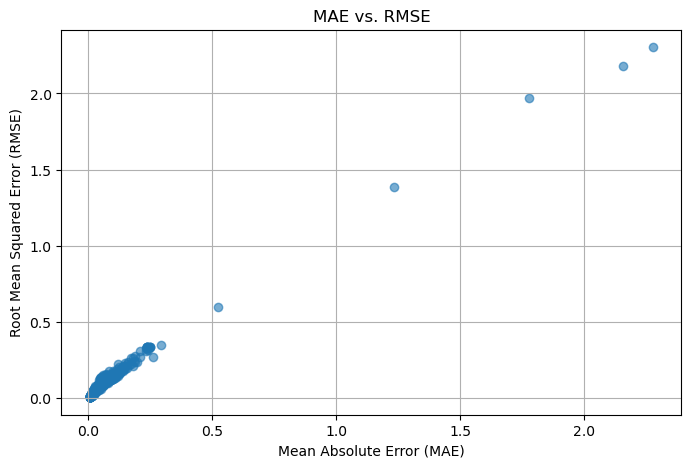

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(df["mae"], df["rmse"], alpha=0.6)
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("MAE vs. RMSE")
plt.grid(True)
plt.show()


## 2.3 R² vs. MAE

The R² score measures how well predictions capture variance in the data.

**Interpretation:**
- Models with higher R² and lower MAE are ideal.
- Low R² despite low MAE may occur if the model fits only a narrow range of the output space.


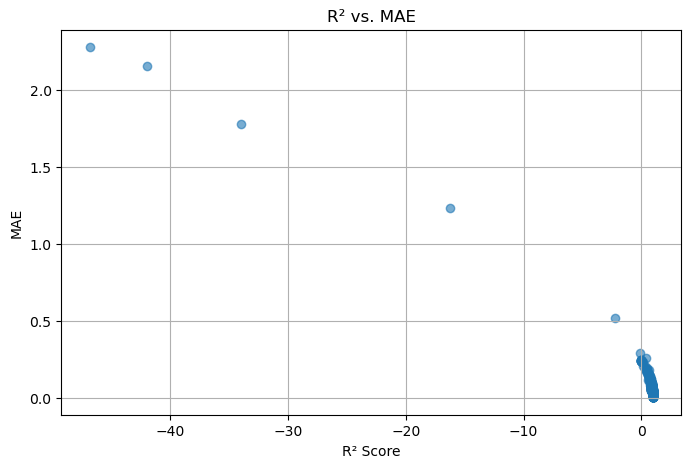

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(df["r2"], df["mae"], alpha=0.6)
plt.xlabel("R² Score")
plt.ylabel("MAE")
plt.title("R² vs. MAE")
plt.grid(True)
plt.show()


## 2.4 Inference Time vs. MAE

This explores the trade-off between model complexity (measured indirectly via inference time) and prediction accuracy.

**Interpretation:**
- Ideally, a model should be both fast and accurate.
- Top-left corner: best-performing models in production settings.


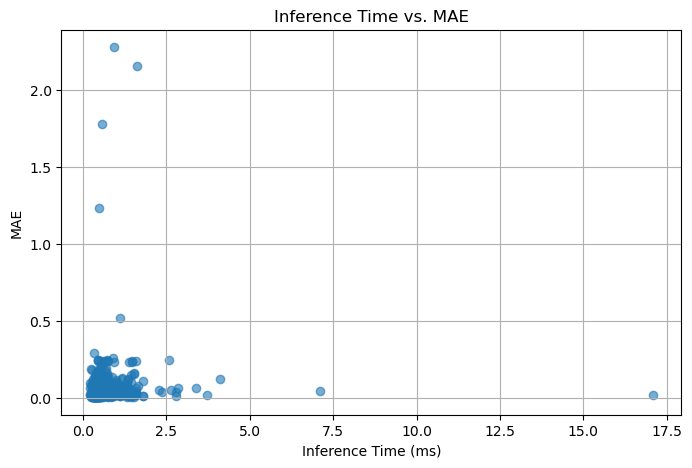

In [14]:
plt.figure(figsize=(8, 5))
plt.scatter(df["inference_time_ms"], df["mae"], alpha=0.6)
plt.xlabel("Inference Time (ms)")
plt.ylabel("MAE")
plt.title("Inference Time vs. MAE")
plt.grid(True)
plt.show()


# 3. Composite Score Evaluation



Instead of relying on a single metric, we compute a composite score that balances multiple evaluation metrics.

**Purpose:** Identify models that perform consistently well across multiple criteria.

**Metrics Used:**
- MAE
- RMSE
- MAPE
- Median Absolute Error
- Validation Loss
- Inference Time

Each metric is normalized to [0, 1] using Min-Max scaling, and the composite score is the average of the normalized values (lower is better).


## 3.1 Normalize and Compute Composite Score

In [15]:
# Define metrics to include in composite score
metrics = ["mae", "rmse", "val_loss_best", "mape", "median_ae", "inference_time_ms"]

# Normalize
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[[f"{m}_norm" for m in metrics]] = scaler.fit_transform(df[metrics])

# Composite score: lower is better
df["composite_score"] = df_norm[[f"{m}_norm" for m in metrics]].mean(axis=1)

# Display top 5 models
df.sort_values("composite_score").head(5)[["model_name", "composite_score"] + metrics]


,model_name,composite_score,mae,rmse,val_loss_best,mape,median_ae,inference_time_ms
527,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.001252,0.005160,0.007443,0.005009,0.272787,0.003680,0.256688
535,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.001345,0.005391,0.009784,0.005846,0.259862,0.003960,0.240936
505,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.002043,0.007099,0.009588,0.000085,0.358925,0.005471,0.316803
528,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.002047,0.005581,0.007874,0.005803,0.304941,0.004177,0.316267
448,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.002181,0.005713,0.007309,0.005315,0.283139,0.005178,0.332909


## 3.2 Composite Score Distribution

This histogram shows how the composite scores are distributed.

**Interpretation:**
- Left tail: best-performing models
- Right tail: consistently poor models


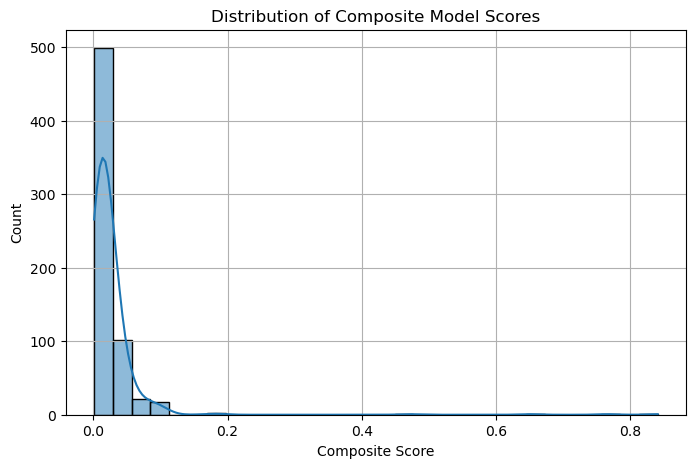

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df["composite_score"], bins=30, kde=True)
plt.xlabel("Composite Score")
plt.title("Distribution of Composite Model Scores")
plt.grid(True)
plt.show()


## 3.3 Composite Score vs. Validation Loss

This scatter plot shows how the composite score relates to validation performance.

**Interpretation:**
- A tight correlation here validates the usefulness of the composite score.
- Outliers may indicate models that are fast but inaccurate, or accurate but slow.


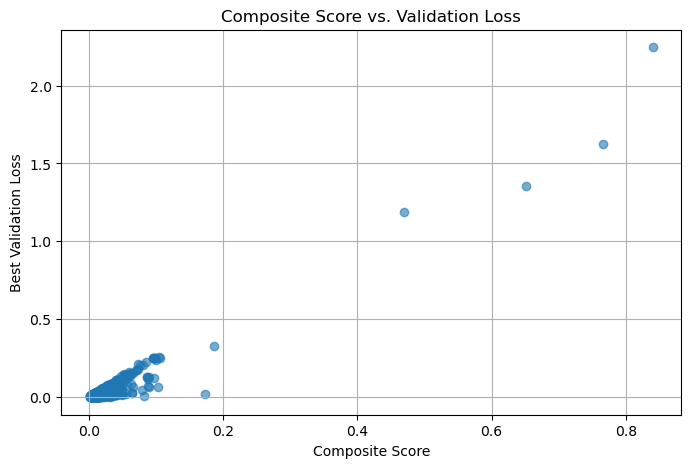

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(df["composite_score"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Composite Score")
plt.ylabel("Best Validation Loss")
plt.title("Composite Score vs. Validation Loss")
plt.grid(True)
plt.show()


# 4. Correlation Analysis



Understanding correlations between metrics helps to:

- Detect redundancy among metrics (e.g., MAE and RMSE often track closely)
- Identify hidden dependencies
- Guide metric selection for composite scores or hyperparameter tuning

We compute the Pearson correlation matrix and visualize it using a heatmap.


## 4.1 Correlation Matrix and Heatmap

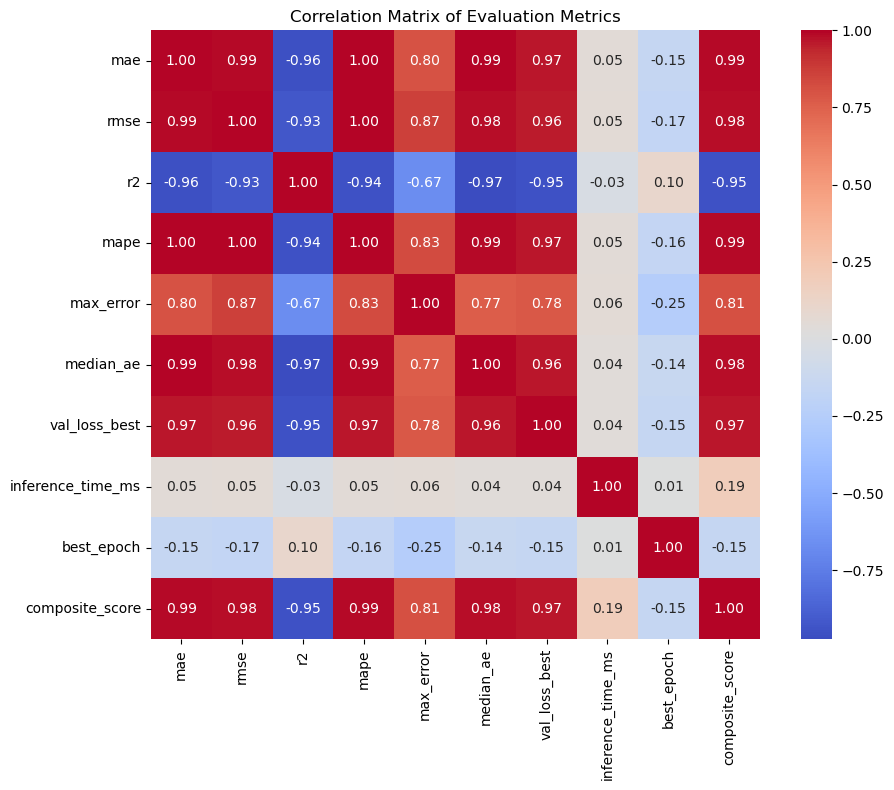

In [18]:
# Select numeric columns of interest
correlation_metrics = [
    "mae", "rmse", "r2", "mape", "max_error", "median_ae",
    "val_loss_best", "inference_time_ms", "best_epoch", "composite_score"
]

# Compute correlation matrix
corr_matrix = df[correlation_metrics].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Evaluation Metrics")
plt.tight_layout()
plt.show()


## 4.2 Observations

After reviewing the heatmap, note:
- Strong correlations between MAE and RMSE are expected.
- High correlation between validation loss and composite score supports its validity.
- Low correlation between inference time and accuracy metrics implies runtime is orthogonal to predictive performance.

Use these insights to refine metric selection and detect redundancies in your evaluation criteria.


# 5. Conclusive Analysis and Top Model Rankings



This section summarizes the evaluation by identifying top-performing models.

We extract:
- The best overall model by composite score
- The best model for each individual metric
- A table summarizing these top models


## 5.1 Best Model by Composite Score

This model is the most balanced across all selected metrics. It represents the best overall trade-off between error, inference speed, and generalization.


In [25]:
best_model = df.sort_values("composite_score").iloc[0]
best_model[["model_name", "composite_score", "mae", "rmse", "r2", "val_loss_best", "inference_time_ms"]]


model_name           model_results_3D_GE_Applied_Current_1MKOH_63_0...
composite_score                                               0.001252
mae                                                            0.00516
rmse                                                          0.007443
r2                                                            0.999501
val_loss_best                                                 0.005009
inference_time_ms                                             0.256688
Name: 527, dtype: object

In [ ]:
best_model[["num_layers", "layer_sizes", "activation", "optimizer", "learning_rate", "batch_size", "dropout_rate"]]

num_layers                     3
layer_sizes      [520, 488, 344]
activation                  gelu
optimizer                  Nadam
learning_rate           0.000622
batch_size                     4
dropout_rate            0.000458
Name: 527, dtype: object

## 5.2 Best Model per Metric

These models individually optimize specific metrics. While they may not be balanced overall, they excel in one particular aspect.


In [20]:
top_by_metric = {}

for metric in ["mae", "rmse", "val_loss_best", "mape", "median_ae", "inference_time_ms", "r2"]:
    ascending = metric != "r2"  # r2 is better when higher
    top_by_metric[metric] = df.sort_values(metric, ascending=ascending).iloc[0]

# Convert to summary DataFrame
top_models_df = pd.DataFrame.from_dict(top_by_metric, orient="index")
top_models_df = top_models_df[[
    "model_name", "mae", "rmse", "r2", "mape", "median_ae", "val_loss_best", "inference_time_ms", "composite_score"
]]
top_models_df


,model_name,mae,rmse,r2,mape,median_ae,val_loss_best,inference_time_ms,composite_score
mae,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.004444,0.005974,0.999678,0.213993,0.003475,0.004321,0.395477,0.002301
rmse,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.004444,0.005974,0.999678,0.213993,0.003475,0.004321,0.395477,0.002301
val_loss_best,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.004956,0.007491,0.999494,0.245984,0.003813,0.000023,0.501945,0.003255
mape,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.004444,0.005974,0.999678,0.213993,0.003475,0.004321,0.395477,0.002301
median_ae,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.004444,0.005974,0.999678,0.213993,0.003475,0.004321,0.395477,0.002301
inference_time_ms,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.098533,0.127451,0.853597,5.260879,0.078438,0.008715,0.194430,0.029797
r2,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.004444,0.005974,0.999678,0.213993,0.003475,0.004321,0.395477,0.002301
